# U-Net | モデルの学習方法と OpenPack Challengeへの提出用ファイル (`submission.zip`) の作成方法

これのノートブックは、[OpenPack Challenge 2022](https://open-pack.github.io/challenge2022/)のチュートリアルとして作成しました。
このチュートリアルでは、左手首の加速度データ (atr02) を入力とし、U-Netを構築・学習する方法を説明します。U-Netはセグメンテーションを行う基本的な構造の1つです。
また、最後にOpenPack Challengeの投稿サイト (Codalab) に提出する `submission.zip` の作成を行います (Development Phase用)。
このチュートリアルのモデルは非常に初歩的で認識精度も十分ではありません。ぜひ、コンペに参加し、このノートブックより認識精度が高いモデルを構築に挑戦してください！


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/unet/notebooks/U-Net_Train-Model-and-Make-Submission-File.ipynb)

**NOTE: このノートブックをcolabで実行する場合は、あらかじめGPUを有効化してください。「ランタイムの変更」から変更できます。**

## [0] 初期設定

### 0-1: サンプルコードのダウンロードとパッケージ (`openpack-torch`) のインストール
NOTE: OpenPack datasetの認識をPyTorchで行う際のユーティティ `openpack-torch` は、PyPIからもインストール (`pip install openpack-torch`) できます。

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [ ]:
! cd /content/openpack-torch/ && pip install .

### 0-2: Google Driveへのデータセットのダウンロード

OpenPack DatasetをGoogle Driveにダウンロードします。ダウンロード先は `/MyDrive/Colab Notebooks/openpack/data` です。
またノートブック内でアクセスしやすいように、ショートカットを `/content/data` に作成します。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# NOTE: データセットをダウンロード済みであれば，このセルの実行はスキップしてください．．
! mkdir -p "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"
! wget https://raw.githubusercontent.com/open-pack/openpack-toolkit/main/tools/download/dl_from_zenodo.sh
! bash ./dl_from_zenodo.sh "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"

In [ ]:
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

### 0-3: モジュールのインポート

In [21]:
import logging
from logging import getLogger
from pathlib import Path
from typing import Dict, Optional

import hydra
import openpack_toolkit as optk
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
from omegaconf import DictConfig, OmegaConf
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

import openpack_torch as optorch
from openpack_torch.lightning import EarlyStopError
from openpack_torch.utils.test_helper import test_helper

from openpack_toolkit import ActSet
from openpack_toolkit.configs.datasets.annotations import (
    OPENPACK_ACTIONS,
    OPENPACK_OPERATIONS,
)
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

### 0-4: ロガーの初期化

1回だけ実行してください。

In [2]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2023-11-19 16:37:55 | INFO | __main__ | info
2023-11-19 16:37:55 | WARNING | __main__ | warning


### 0-5: 乱数種の初期化

ニューラルネットワークの学習では、大量の乱数が生成され、その生成された乱数がモデルのパフォーマンスに大きな影響を与えます。
再現性を上げるため、実行前に乱数種を固定しましょう。

In [3]:
optorch.utils.reset_seed(seed=0)

2023-11-19 16:37:56 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


## [1] 設定ファイル (デフォルトパラメータ) の読み込み

### 1-1: Overview of Config Files

ニューラルネットワークを学習する際には非常にたくさんのハイパーパラメータの設定が必要です。しかしそれらを管理するのは容易ではありません。
ハイパーパラメータを管理するためのツールが多数公開されており、このノートブックでは [hydra](https://hydra.cc/) を使用して、ハイパーパラメータの管理を行います。

今回はデフォルトのパラメータをそのまま使用しますが、[configs](https://github.com/open-pack/openpack-torch/tree/main/examples/unet/configs) にあるようなYAMLファイルを編集することでデフォルトのパラメータを変更することができます。
変更方法の詳細に関しては、別のチュートリアルを参考にしてください。


### 1-2: `openpack-toolkit` で定義されているデフォルトパラメータの読み込み

`openpack-torch` の関数を使って、`openpack-toolkit` で定義されているデフォルトのパラメータをHydraに事前に登録します。

In [4]:
optorch.configs.register_configs()

### 1-3: 設定ファイルの読み込み

[/content/openpack-torch/examples/unet/configs](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml) にある設定ファイルを読み込みます。
このノートブックでは、YAMLファイルをカレントディレクトリにコピーし、そこからデフォルトのパラメータを読み込みます。
デフォルトのパラメータを一部変更したい場合は、設定ファイルをGoogle Driveに保存して編集してください。
Learning rateなどを一時的に変更する場合は、 `hydra.compose()` の `overrides` から変更することができます。


In [5]:
! cp -r /content/openpack-torch/examples/configs /content/

In [6]:
overrides = [
    "mode=train",
    "metadata.labels.issue=I01-EXP1-V1-nb", # subdirectry for logging
    
    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=true",

    # -- path.logdir.rootdir --
    "path.openpack.version=v1.0.0",
    "path.openpack.rootdir=/content/data/datasets/openpack/${path.openpack.version}/",
    
    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/data/XXX` (symling to Google Drive), `/content/drive/XXX`)
    "path.logdir.rootdir=/content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}",
    
    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="unet.yaml",
        overrides=overrides,
    )

# -- Data Split --
# Change Train/Val/Test/Submission set to submit for Development Phase.
# Please comment out the following block when you want to train on the main set.
cfg.dataset.split = optk.configs.datasets.splits.DEBUG_SPLIT

# (default value)
# cfg.dataset.split = optk.configs.datasets.splits.OPENPACK_CHALLENGE_2022_SPLIT

In [7]:
print(OmegaConf.to_yaml(cfg))

run: 0
debug: true
mode: train
path:
  openpack:
    version: v1.0.0
    rootdir: /content/data/datasets/openpack/${path.openpack.version}/
  datasets:
    openpack: ${path.openpack.rootdir}
  logdir:
    rootdir: /content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}
    model: ${path.logdir.rootdir}/model.pth
    predict: ${path.logdir.rootdir}/pred/${train.checkpoint}/{user}-{session}
    summary:
      rootdir: ${path.logdir.rootdir}/summary/${train.checkpoint}
      train: ${.rootdir}/train.csv
      test: ${.rootdir}/test.csv
      test-b2: ${.rootdir}/test-b2.csv
      test-b3: ${.rootdir}/test-b3.csv
      submission: ${.rootdir}/submission.csv
dataset:
  annotation:
    kind: dataset/annotation/csv/sequence
    name: openpack-operations-1hz-annotation
    metadata:
      labels:
        type: annotation/operation
        version: v3.5.0
        dependency:

## [2] ユーティリティの設定 (Pytorch Lightning Modules)

### 2-1: DataModule

IMUを読み込むのデータセットクラスを利用するには、`optorch.data.OpenPackBaseDataModule` を継承したDataModuleクラスを作成し、`dataset_class` に `optorch.data.datasets.OpenPackImu` を設定します。
IMU用のデータセットクラスは[こちら](https://github.com/open-pack/openpack-torch/blob/main/openpack_torch/data/datasets.py)で定義されています。
カスタムデータセットを実装する場合は、実装したデータセットクラスを `dataset_class` に設定してください。

データセットクラスを初期化するためのパラメータは `get_kwargs_form_datasets()` メソッドで用意する必要があります。
データセットクラスは `get_kwargs_form_datasets()` の出力である `kwargs` を用いて、以下のように初期化されます。

```python
# https://github.com/open-pack/openpack-torch/blob/6c6933e24c7c3311e582ebf3aac1a659467be0fb/openpack_torch/data/datamodule.py#L91
self.op_train = self.dataset_class(self.cfg, split.train, **kwargs)
```

In [8]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

`init_model()` メソッドで、モデルを初期化します。

`init_criterion()` メソッドでは、カスタムの損失関数を定義します。
ただし、スコアの計算から除外したいクラスは評価から除外してください。 OpenPack Datasetの場合は、"Null (ID8100)" が該当します。
例えば、`torch.nn.CrossEntropyLoss` では、 `ignore_class` パラメータにNullクラスのインデックス `10` を指定することで、スコア計算から除外できます。

In [9]:
class UNetLM(optorch.lightning.BaseLightningModule):
    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        dim = 0
        if self.cfg.dataset.stream.spec.imu.acc:
            dim += 3
        if self.cfg.dataset.stream.spec.imu.gyro:
            dim += 3
        if self.cfg.dataset.stream.spec.imu.quat:
            dim += 4

        input_dim = len(self.cfg.dataset.stream.spec.imu.devices) * dim
        output_dim = len(self.cfg.dataset.annotation.spec.classes)
        model = optorch.models.imu.UNet(
            input_dim,
            output_dim,
            depth=cfg.model.spec.depth,
        )
        return model

    def train_val_common_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        self.test_step_outputs.append(outputs)
        return outputs


## [3] U-Netの学習

### 3-1: U-Net と DataLoader の初期化

In [10]:
device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

In [11]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (0): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 1), strid

### 3-2: Trainerの初期化

In [12]:
max_epoch = (
    cfg.train.debug.epochs.maximum if cfg.debug else cfg.train.epochs.maximum
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    mode=cfg.train.early_stop.mode,
    monitor=cfg.train.early_stop.monitor,
    filename="{epoch:02d}-{train/loss:.2f}-{val/loss:.2f}",
    verbose=False,
)

early_stop_callback = pl.callbacks.EarlyStopping(
    **cfg.train.early_stop,
)

pl_logger = pl.loggers.CSVLogger(logdir)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=1,
    max_epochs=max_epoch,
    logger=pl_logger,
    default_root_dir=logdir,
    enable_progress_bar=True,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=4,
)
logger.debug(f"logdir = {logdir}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: 学習

In [13]:
logger.info(f"Start training for {max_epoch} epochs.")
try:
    trainer.fit(plmodel, datamodule)
except EarlyStopError as e:
    logger.warning(e)
logger.info(f"Finish training! (logdir = {logdir})")

2023-11-19 16:38:11 | INFO | __main__ | Start training for 10 epochs.
Missing logger folder: /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/lightning_logs
2023-11-19 16:38:11 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=129, num_sequence=3, submission=False, random_crop=True)
2023-11-19 16:38:11 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0102-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f9643b66650>}
2023-11-19 16:38:11 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2023-11-19 16:38:11 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-11-19 16:38:11 | INFO | openpack_torch.lightning | Adam optimizer is selected! (lr=0.001)
2023-11-19 16:38:11 | INFO | openpack_torch.lightning | StepLR scheduler is selected.

  | Name      | Type             | Params
--------------

Epoch 0: 100% 17/17 [00:00<00:00, 31.69it/s, v_num=0]          
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0% 0/5 [00:00<?, ?it/s]        
Validation DataLoader 0:   0% 0/5 [00:00<?, ?it/s]
Validation DataLoader 0:  20% 1/5 [00:00<00:00, 99.66it/s]
Validation DataLoader 0:  40% 2/5 [00:00<00:00, 110.94it/s]
Validation DataLoader 0:  60% 3/5 [00:00<00:00, 116.34it/s]
Validation DataLoader 0:  80% 4/5 [00:00<00:00, 115.61it/s]
Validation DataLoader 0: 100% 5/5 [00:00<00:00, 92.06it/s] 
Epoch 1: 100% 17/17 [00:00<00:00, 42.65it/s, v_num=0, val/loss=2.390, val/acc=0.0792, train/loss=2.210, train/acc=0.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0% 0/5 [00:00<?, ?it/s]        
Validation DataLoader 0:   0% 0/5 [00:00<?, ?it/s]
Validation DataLoader 0:  20% 1/5 [00:00<00:00, 98.32it/s]
Validation DataLoader 0:  40% 2/5 [00:00<00:00, 100.16it/s]
Validation DataLoader 0:  60% 3/5 [00:00<00:00, 102.25it/s]
Validation DataLoader 0:  80% 4/5 [00:00<00:00, 107

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100% 17/17 [00:01<00:00, 15.71it/s, v_num=0, val/loss=1.610, val/acc=0.447, train/loss=1.630, train/acc=0.419]


2023-11-19 16:38:23 | INFO | __main__ | Finish training! (logdir = /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0)


### 3-4: 学習曲線の確認

学習時のloss, accuracyは `plmodel.log_dict` (dict) に格納されています。
Training setと validation setの学習曲線を描画してみましょう。

In [14]:
pl_logdir = Path(cfg.path.logdir.rootdir, "lightning_logs/")
latest_logdir = list(sorted(pl_logdir.iterdir()))[-1]

df = pd.read_csv(Path(latest_logdir, "metrics.csv"))
df["phase"] = df["train/loss"].apply(lambda x: "val" if np.isnan(x) else "train")
df = df.set_index(["epoch", "phase"])

In [15]:
df.head()

val/acc  step  val/loss  train/acc  train/loss
epoch phase                                                 
0     val    0.079158    16  2.387381        NaN         NaN
      train       NaN    16       NaN   0.269626    2.211701
1     val    0.180532    33  2.344906        NaN         NaN
      train       NaN    33       NaN   0.341599    2.001790
2     val    0.245741    50  2.124828        NaN         NaN

Training Log

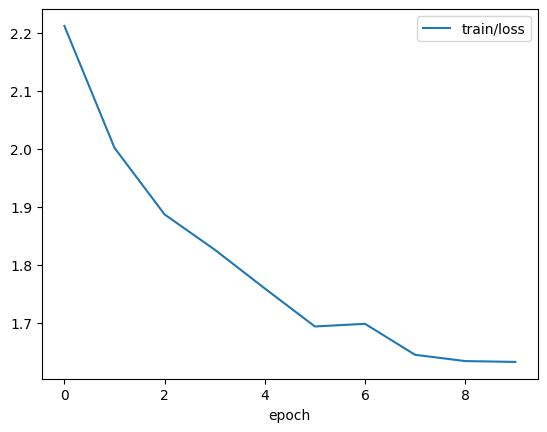

In [16]:
df.xs("train", level="phase")[["train/loss"]].plot()
plt.show()

Test Log

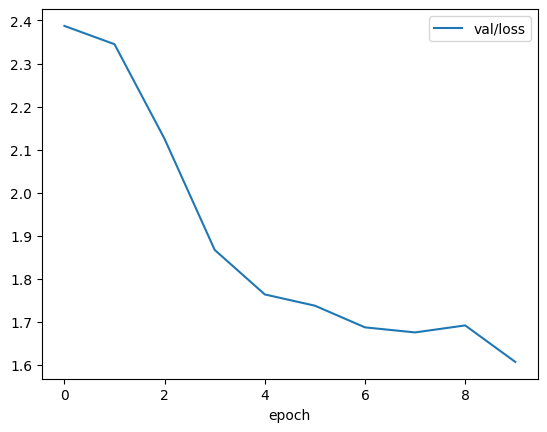

In [17]:
df.xs("val", level="phase")[["val/loss"]].plot()
plt.show()

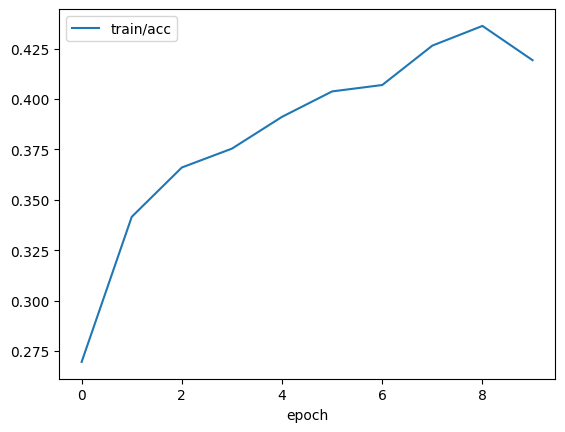

In [18]:
df.xs("train", level="phase")[["train/acc"]].plot()
plt.show()

## [4] Test データでの評価

OpenPack Challengeでも使用されている評価関数は、 `optk.codalab.eval_operation_segmentation_wrapper()` として定義されています。
この関数は2番目の引数としてdictを受け取ります。dictは、以下のような形式で、セッションごと (`{user}-{session}`, e.g., `U0107-S0100`) に、予測結果 (`y`)、ground truth (`t_idx`)、unixtime (`unixtime`) を含みます。


```python
outputs = {
    "U0102-S0100": {
        "t_idx": [0, 0, ...], # groundtruth (class index)
        "y": [
            [
                [0., 0., ...],
                [0., 0., ...],
                [1., 1., ...],
            ],
        ], # prediction. shape=(B,N_CLASSES,T), dtype=float
        "unixtiume": [634885794000, 1634885794200, ...], # unixtime
    },
    "U0102-S0200": {
        "t_idx": [...], 
        "y": [...],
        "unixtiume": [...],
    },
    ...
}
```

### 4-1: 各セッションのデータに対する推論と結果のdictの作成

NOTE: `DEBUG_SPLIT` (デフォルト) では、`U0102-S0500` を使用しています。このセッションは "Development Phase" の評価対象のセッションです。

In [19]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f9642455e10>}
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2023-11-19 16:38:31 | INFO | __main__ | test on U0102-S0500
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f9642470700>}
2023-11-19 16:38:31 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100% 4/4 [00:00<00:00, 24.22it/s] 


2023-11-19 16:38:31 | INFO | __main__ | save t[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/t.npy
2023-11-19 16:38:31 | INFO | __main__ | save y[shape=(31, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/y.npy
2023-11-19 16:38:31 | INFO | __main__ | save unixtime[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/unixtime.npy


### 4-2: スコア計算

In [22]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    cfg, outputs, ActSet(OPENPACK_OPERATIONS),
)

2023-11-19 16:39:03 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1634887609000]
2023-11-19 16:39:03 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | fill missing element at ts=1634887609000 (ind=1822) with 100.


In [23]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
12,avg/macro,-1,0.357193,0.329638,0.317168,None,all
13,avg/weighted,-1,0.365126,0.370227,0.346800,None,all
14,Picking,100,0.310484,0.493590,0.381188,156,all
15,Relocate Item Label,200,0.303922,0.242188,0.269565,384,all
16,Assemble Box,300,0.509174,0.430233,0.466387,258,all
17,Insert Items,400,0.354167,0.119718,0.178947,142,all
18,Close Box,500,0.304527,0.418079,0.352381,177,all
19,Attach Box Label,600,0.352941,0.093750,0.148148,64,all
20,Scan Label,700,0.443515,0.765343,0.561589,277,all
21,Attach Shipping Label,800,0.395833,0.191919,0.258503,99,all


### 4-3: モデルの出力の可視化

モデルの出力を `softmax()` 関数で確率に変換し、Confidence Scoreをヒートマップとして可視化しましょう。

In [24]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )
    # ax0.plot(
    #     x, pred + 0.5, label="pred",
    #     linewidth=1, color="C1", alpha=0.5,
    # )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


In [25]:
key = "U0102-S0500"

unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(31, 1800), t_idx=(31, 1800), y=(31, 11, 1800), y_softmax=(31, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


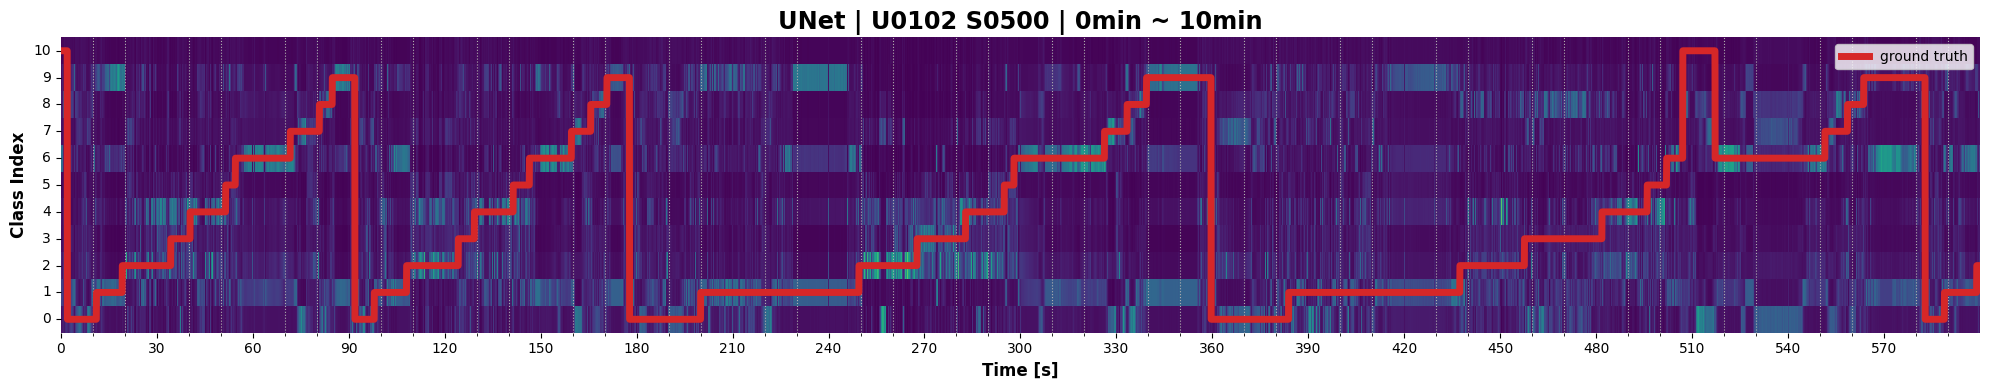

In [26]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

prob=(11, 18000) pred=(18000,), gt=(18000,)


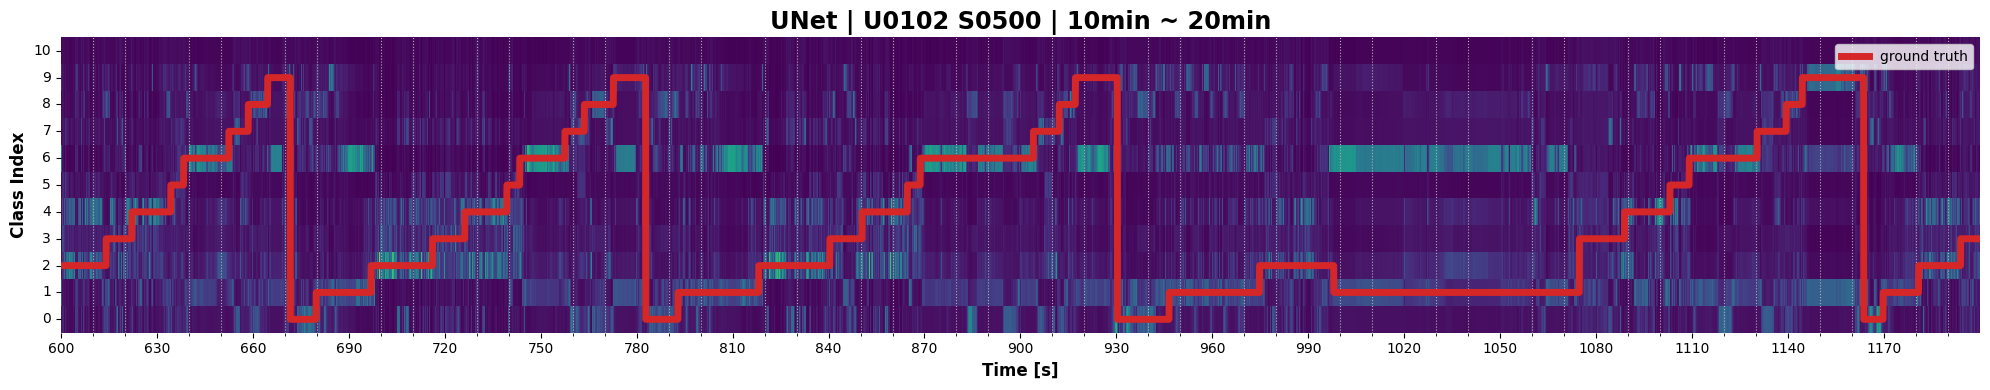

In [27]:
samples = (10, 20)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

## [5] OpenPack Challengeへの提出用ファイルの作成

予測結果の提出用サイト (Codalab) へアップロードするzipファイルの作成には、`optk.codalab.construct_submission_dict()` を使用することができます。

基本的に引数として渡すdictの構成は基本的に`optk.codalab.eval_operation_segmentation_wrapper()` と同じですが、ground truthは含みません。

### 5-1: 本番用テストデータでの推論

In [ ]:
cfg.mode = "submission"
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

### 5-2: 提出用のzipファイルの作成

`construct_submission_dict()` を使用することで、以下の処理ができます。

- モデルの出力 `y` (3D tensor) をクラスIDに変換
- サンプリングレートを1 Hzに変更
- 評価対象範囲外のデータの除去

また、`make_submission_zipfile()` を使用することで、以下の処理ができます。

- `submission_dict` から `prediction` と `unixtime` を抜き出す。
- `submission.json` 及び `submission.zip` を作成 (出力先は、`output_dir` で指定)


In [ ]:
output_dir = str(cfg.path.logdir.rootdir)

submission_dict = construct_submission_dict(outputs, OPENPACK_OPERATIONS)
make_submission_zipfile(submission_dict, output_dir)

### 5-3: 作成した `submission.zip` を Codalab に投稿しましょう！

`submission.zip` ファイルの作成ができたと思います。
是非作成した予測結果を、コンペの予測結果提出用サイト (Codalab) に提出し、スコアを確認しましょう！


NOTE: `optk.configs.datasets.splits.DEBUG_SPLIT` (このノートブックのデフォルト値)を使用している場合は、"Development Phase" に提出してください。